In [12]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from graphviz import Digraph

In [12]:
import os
os.environ["PATH"] += os.pathsep + 'D:/software/graphviz/Graphviz-12.2.1-win64/bin'

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [14]:
class Value:
    def __init__(self,data,_children=(),_op = '',label = ''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda : None
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(={self.data})"
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        
        
        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out._backward = _backward
        
        return out
    def __mul__(self,other):
        
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
        
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,),f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self,other):
        return self *  other

    def __truediv__(self,other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other)

    def __radd__(self,other):
        return self +  other
    
    def tanh(self):
        x = self.data
        tn = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(tn,(self,),'tanh')

        def _backward():
            self.grad += (1 - tn **2) * out.grad
        out._backward = _backward
        
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self, ),'exp')

        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()
            
        



    
    

In [15]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(=-8.0)

In [16]:
h = Value(4.0,label = 'h')
j = Value(6.0 , label = 'j')

In [17]:
d = j - h

In [18]:
d

Value(=2.0)

In [19]:
e = (d*2).exp()

In [20]:
e

Value(=54.598150033144236)

In [21]:


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

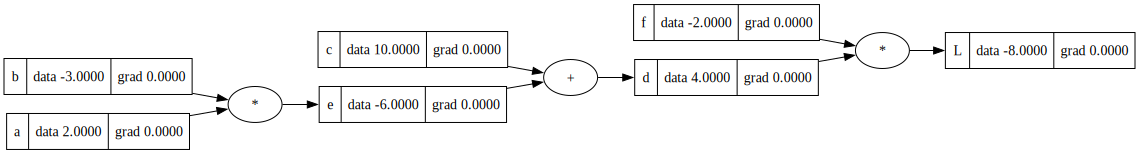

In [22]:
draw_dot(L)

In [23]:
a.grad = 6
b.grad = -4

In [24]:
def lll():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h)
    

In [25]:
lll()

1.000000000000334


In [26]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'

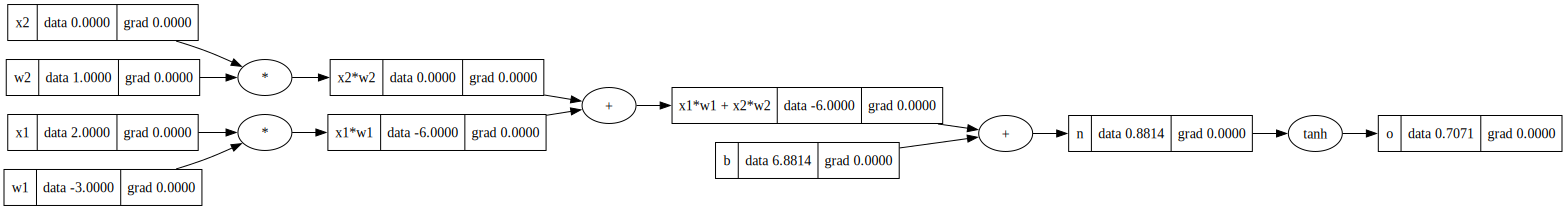

In [27]:
draw_dot(o)

In [28]:
o.backward()

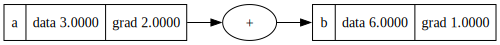

In [29]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

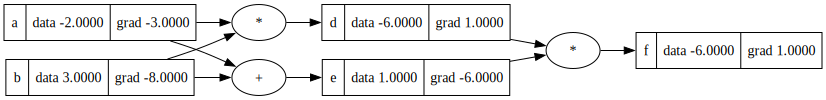

In [30]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

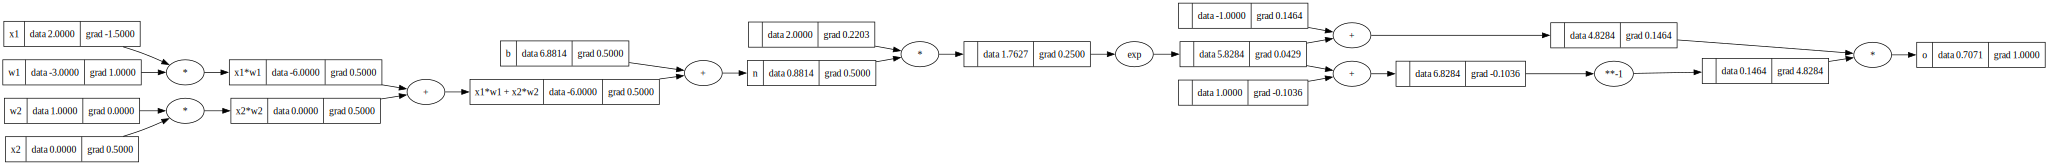

In [31]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [32]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(=-8.0)

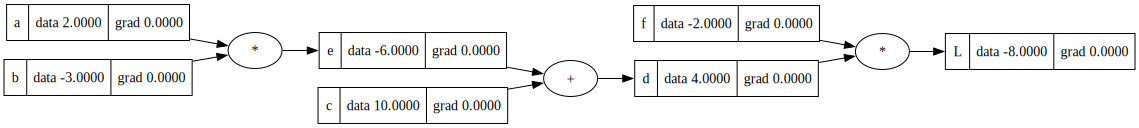

In [33]:
draw_dot(L)

In [48]:

class Neuron:
    def __init__(self,nim):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nim)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        self.w + [self.b]

class Layers:
    def __init__(self,nim,nnout):
        self.neurons = [Neuron(nim) for _ in range(nnout)]
    
    def __call__(self,x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]
class MLP:
    def __init__(self,nim,nnout):
        siz = [nim] + nnout
        self.layers = [Layers(siz[i] , siz[i]+1) for i in range (len(nnout))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters():
        return [p for layer in self.layers for p in layer.parameters()]

In [49]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(=-0.8500122600485653),
 Value(=-0.33991411693417406),
 Value(=0.9545014780358942),
 Value(=0.4715145933344197),
 Value(=-0.13034412401582018)]

In [50]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [51]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

TypeError: unsupported operand type(s) for -: 'list' and 'float'